## Project: Determining age of customers

The supermarket chain `Good Seed` would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. The purpose of this project was to conduct this evaluation by using methods of Computer Vision while keeping in mind the following specifications:

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- The task then is to build and evaluate a model for verifying people's age
- For this project, we were provided with photographs of people with their ages indicated.

### Libraries Used for Analysis 

In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Load Data

The datasets below were stored in the `/datasets/faces/` folder
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it was advisable to avoid reading them all at once, which would greatly consume computational resources. We built generator with the ImageDataGenerator generator. 

In [11]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1/255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [12]:
train_1 = next(train_gen_flow)
def show_batch(batch):
    fig, axs = plt.subplots(3,3, figsize=(10, 6))
    for i in range(9):
        row = i // 3
        col = i % 3
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        ax.set_title(f'age: {real_age}', fontsize='medium')
    fig.tight_layout()

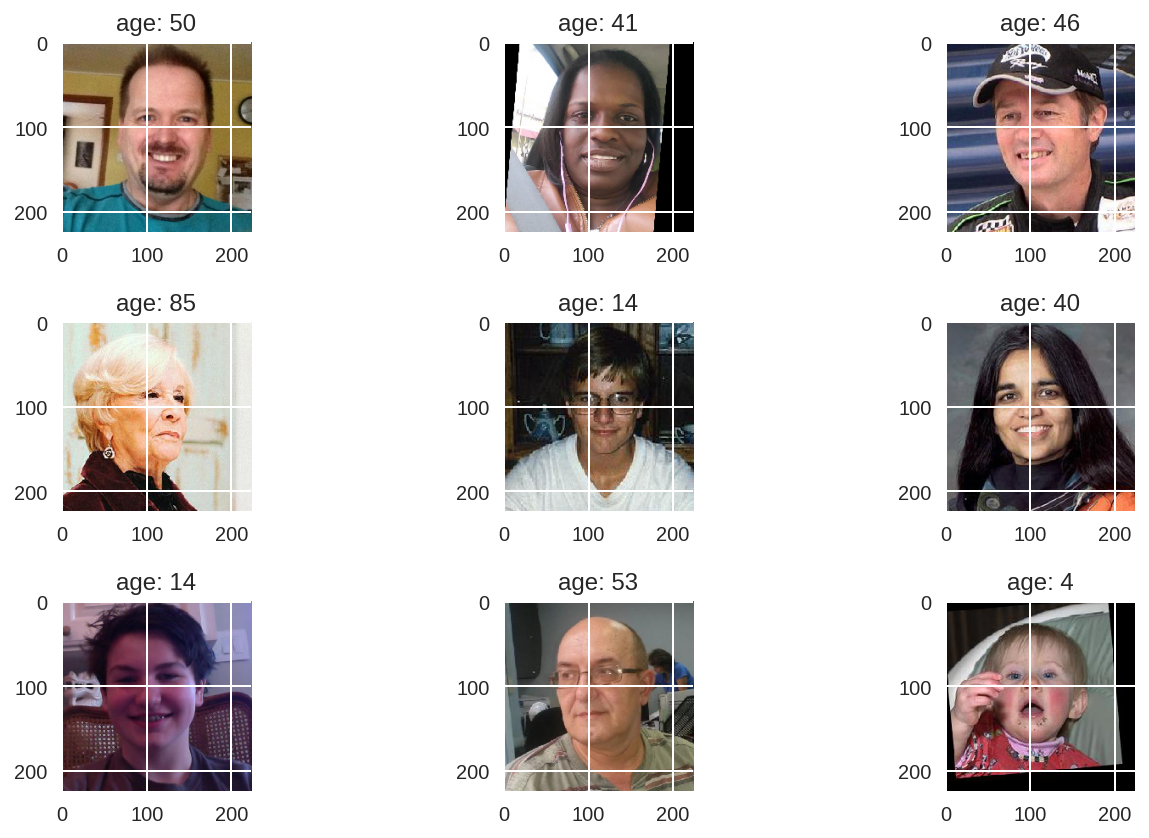

In [13]:
show_batch(train_1)

## Exploratory Data Analysis

### Distribution of 'real_age' values

From the histogram and the kernel density estimate distributions below, we observed that the `real_age` values distribution is postively skewed, and presented a mean value of 31.20 years; a median values of 29.0 years; and a standard deviation of 17.14 years. From this distribution, we noticed that 50% of the `real_age` values were between the ages of 41 and 20 years of age. Wel also had a minimum value of 1 years old, and a maximum values of 100 years old. 

In [14]:
#real age distribution
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

[]

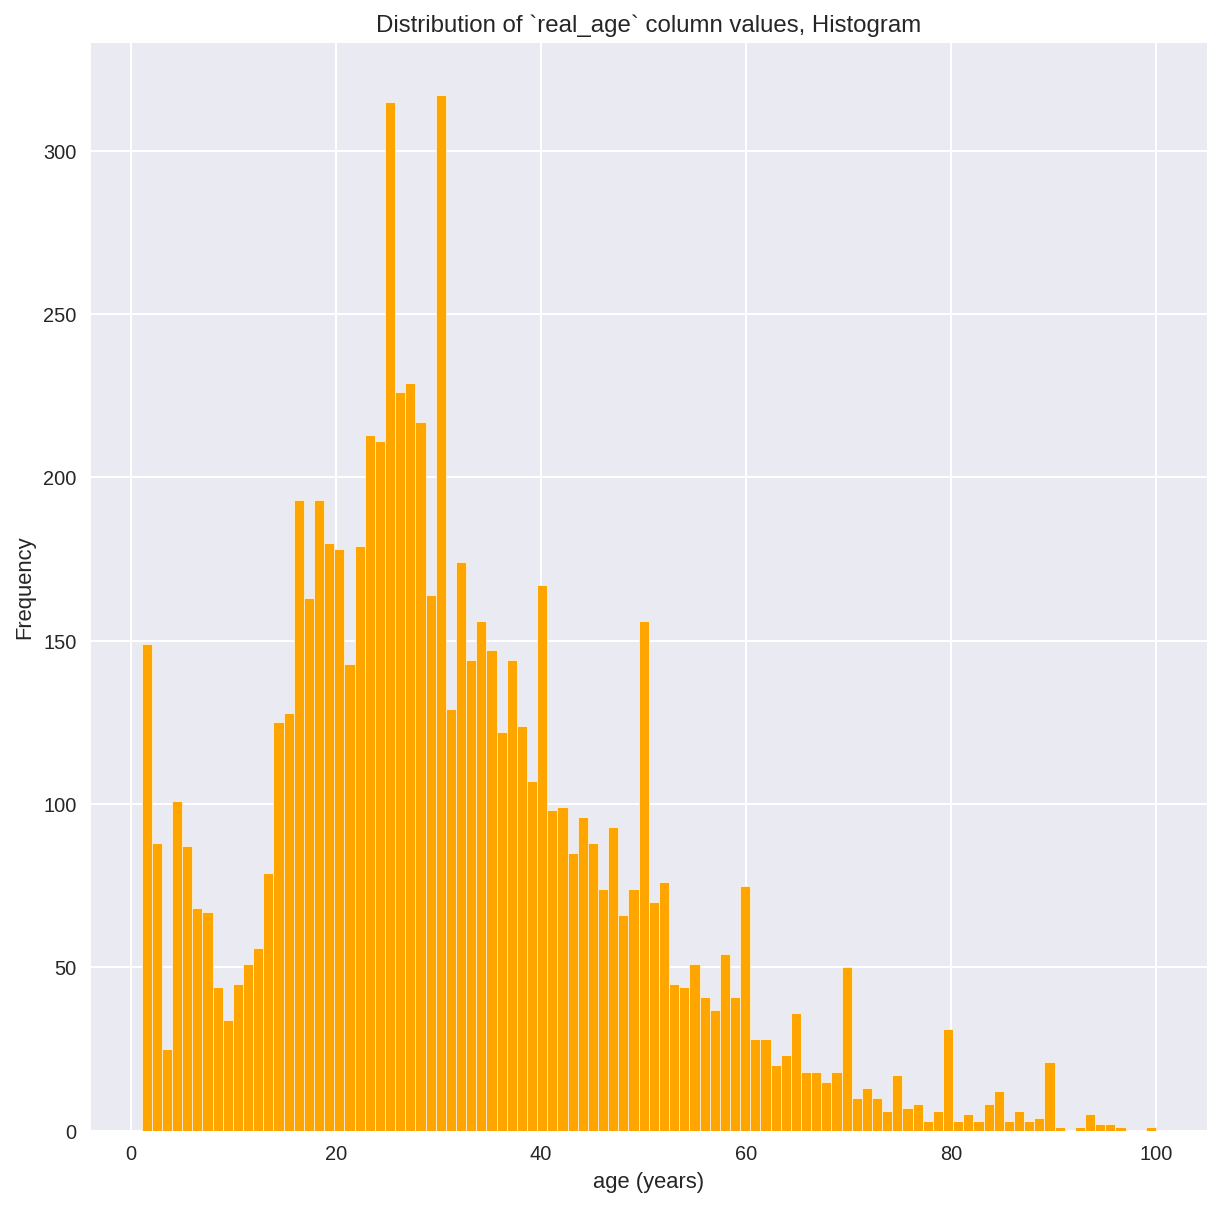

In [15]:
labels.real_age.plot(kind='hist', figsize=(10,10), bins=100, color='orange')
plt.title('Distribution of `real_age` column values, Histogram')
plt.xlabel('age (years)')
plt.plot()

[]

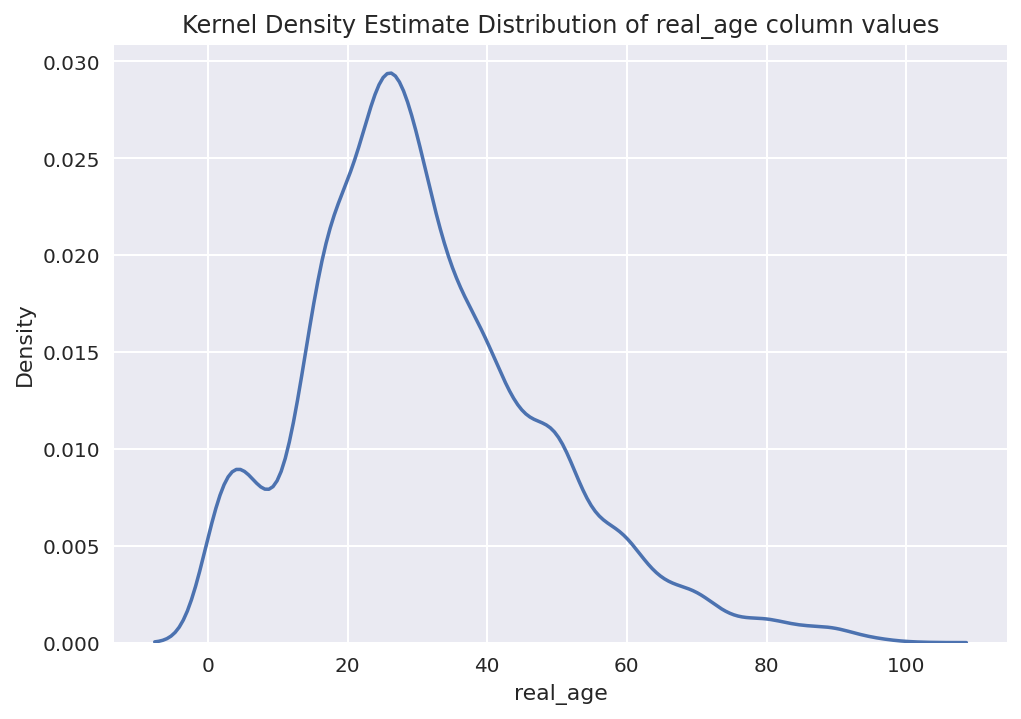

In [16]:
sns.kdeplot(data=labels, x="real_age")
sns.set(rc={"figure.figsize":(10, 10)})
plt.title("Kernel Density Estimate Distribution of real_age column values")
plt.plot()

From the `real_age` column values, we observed that there were 169 outliers greater than 1.5 * IQR. 

In [8]:
q1= labels.real_age.quantile(0.25)
q3= labels.real_age.quantile(0.75)
iqr = q3-q1

#calculating number of outliers in column 
len(labels.query('real_age > (@q3 + 1.5*@iqr)'))

169

### Distribution of ouliers for 'real_age' values

From the outliers that were greater than 1.5 * Iqr, we found that the distribution of the outliers was postively skewed, with a mean of 82.26 years; a median of 8 years; and a standard deviation of 6.4 years. 

         real_age
count  169.000000
mean    82.260355
std      6.402448
min     73.000000
25%     77.000000
50%     80.000000
75%     87.000000
max    100.000000


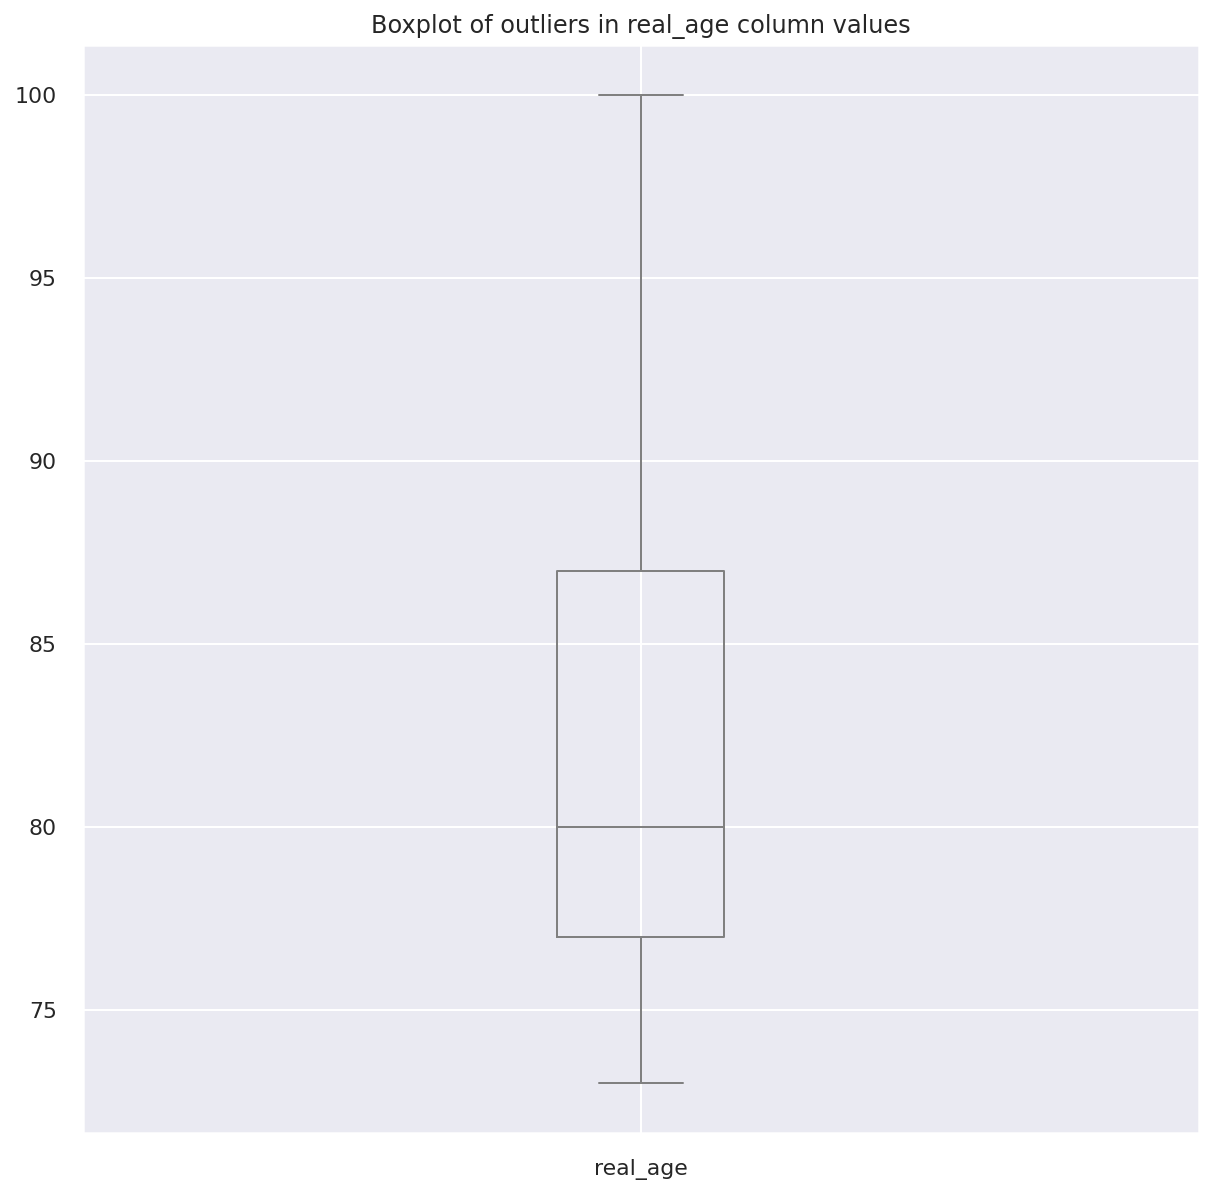

In [21]:
# Analyzing outliers in real_age colum values
label_out = labels.query('real_age > (@q3 + 1.5*@iqr)')
label_out.real_age.plot(kind='box', figsize=(10,10), color='grey')
plt.title('Boxplot of outliers in real_age column values')
print(label_out.describe())
plt.plot()
plt.show()


### Distribution of underage 'real_age' values

From the distribution of underage in `real_age` column values, we found out that the mean value was 12.39 years; the median value was 15 years; and the standard deviation values was 6.26 years. The distribution did not appear as a normal distribution. 

          real_age
count  2054.000000
mean     12.398734
std       6.268565
min       1.000000
25%       6.000000
50%      15.000000
75%      18.000000
max      20.000000


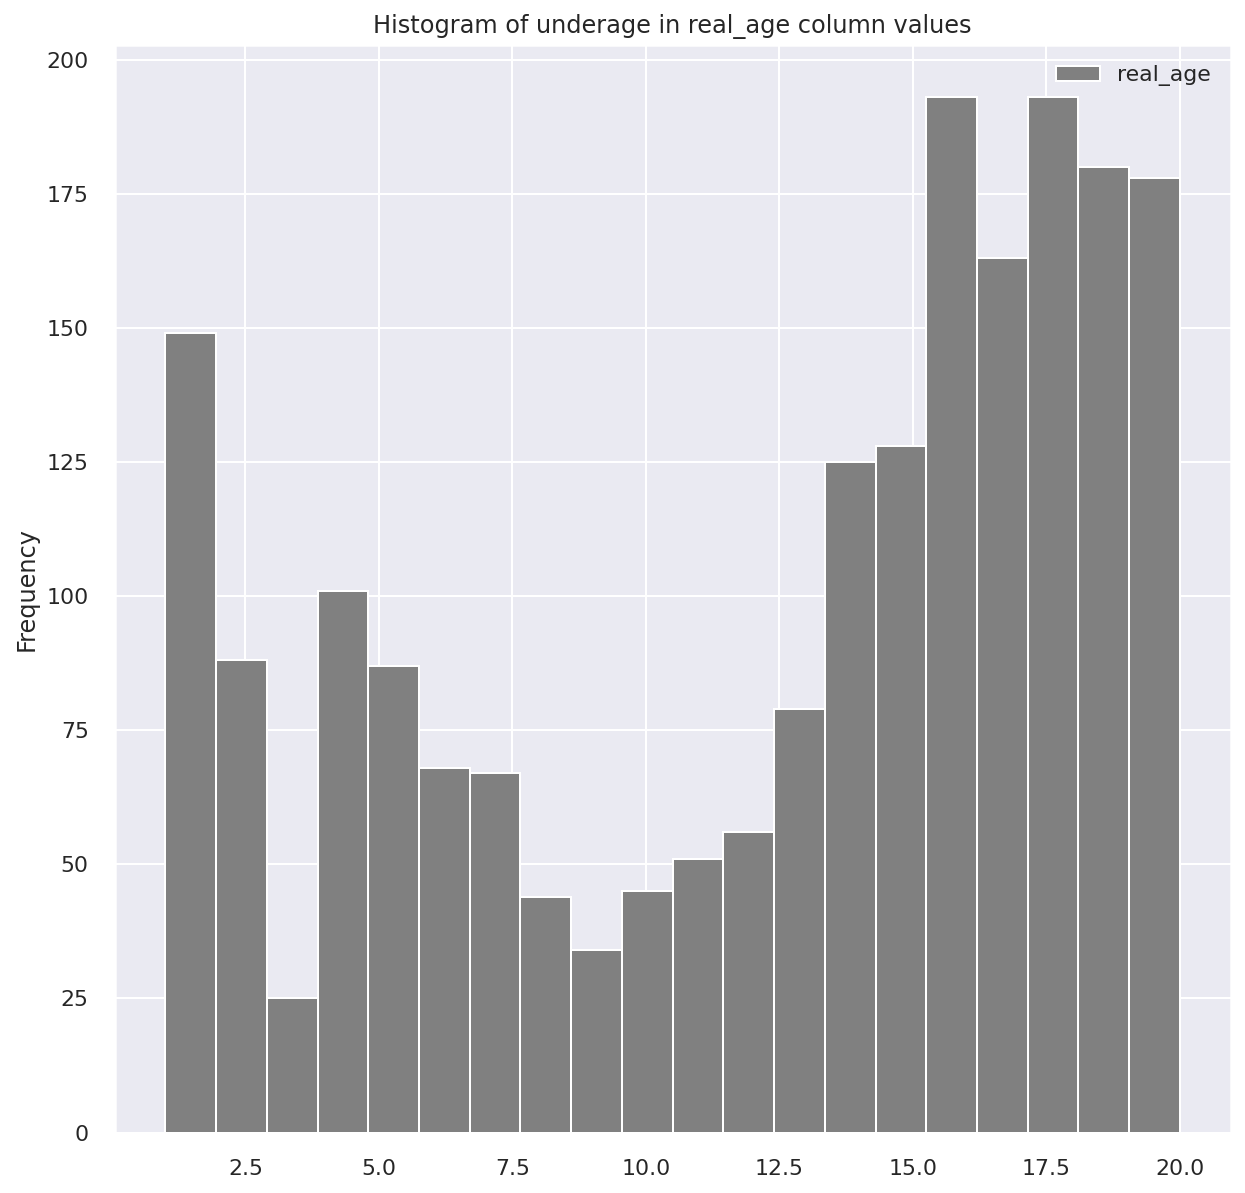

In [25]:
real_age_underage = labels.query('real_age<21')
real_age_underage.plot(kind='hist', figsize=(10,10), color='grey', bins=20)
plt.title('Histogram of underage in real_age column values')
print(real_age_underage.describe())
plt.plot()
plt.show()

### Distribution of underage vs. legal age to buy alcohol values.

In this section we explored the distribution, portrayed in the bar plot below, of the age_classification of real_age values. From the bar plot, we concluded that 72.94% of the values in real_age are classified as 'legal_age', which means that we have 72.94% of image data of people who can legally buy alcohol. On the contrary, we have 27.06% of image data for people who cannot legally buy alcohol. 

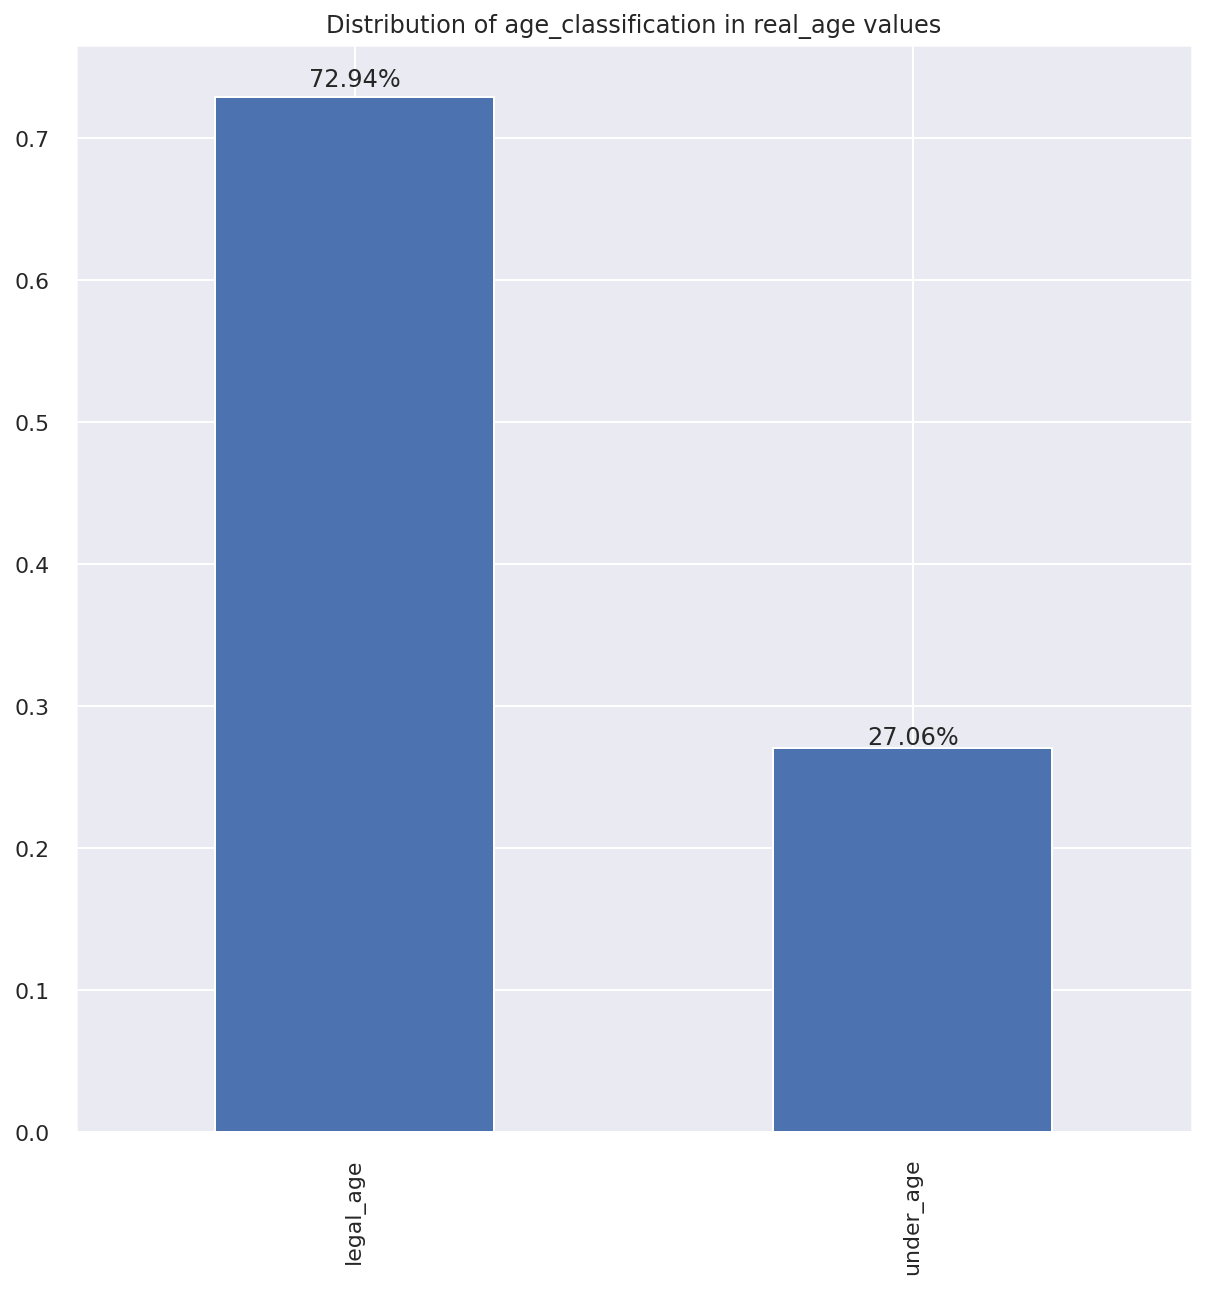

In [42]:
def age_eval(row):
    real_age = row['real_age']
    
    if real_age < 21:
        return 'under_age'
    return 'legal_age'

labels_copy = labels
labels_copy['age_classification'] = labels_copy.apply(age_eval, axis =1)
class_plot = labels_copy.age_classification.value_counts(normalize = True).plot(kind = 'bar')

for p in class_plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    class_plot.annotate(f'{height:.2%}', (x + width/2, y + height*1.01), ha='center')
plt.title('Distribution of age_classification in real_age values')
plt.plot()
plt.show()

## Conclusion from Exploratory Data Analysis


From the exploratory data analysis we conclude that the real_age values distribution is postively skewed, and presented a mean value of 31.20 years; a median values of 29.0 years; and a standard deviation of 17.14 years. From this distribution, we noticed that 50% of the real_age values were between the ages of 41 and 20 years of age. Wel also had a minimum value of 1 years old, and a maximum values of 100 years old. Similarly, from the outliers that were greater than 1.5 * Iqr, we found that the distribution of the outliers was postively skewed, with a mean of 82.26 years; a median of 8 years; and a standard deviation of 6.4 years. On the contrary, from the distribution of underage in `real_age` column values, we found out that the mean value was 12.39 years; the median value was 15 years; and the standard deviation values was 6.26 years. The distribution did not appear as a normal distribution. Finally,  we concluded that 72.94% of the values in real_age are classified as 'legal_age', which means that we have 72.94% of image data of people who can legally buy alcohol. On the contrary, we have 27.06% of image data for people who cannot legally buy alcohol. 

## Modelling

In this section, we defined the functions we used to train your model on the GPU platform and built a single script containing all of them along with the initialization section.


In [3]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow



In [4]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

In [5]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [6]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

## Prepare the Script to Run on the GPU Platform

Given that we have defined the necessary functions, we composed a script for the GPU platform, downloaded it via the "File|Open..." menu, and uploaded it later for running on the GPU platform. The script included the initialization section as well.

In [7]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

In this section, we placed the output from the GPU platform as an Markdown cell here.

Using TensorFlow backend.


Found 5694 validated image filenames.


Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 58s - loss: 214.5732 - mae: 11.1197 - val_loss: 375.0771 - val_mae: 14.4656


Epoch 2/20
356/356 - 39s - loss: 133.0480 - mae: 8.8133 - val_loss: 214.9678 - val_mae: 11.1725


Epoch 3/20
356/356 - 39s - loss: 109.1604 - mae: 7.9093 - val_loss: 323.4738 - val_mae: 13.5732


Epoch 4/20
356/356 - 39s - loss: 94.7783 - mae: 7.4209 - val_loss: 119.4038 - val_mae: 8.1934


Epoch 5/20
356/356 - 39s - loss: 78.5183 - mae: 6.7542 - val_loss: 116.0025 - val_mae: 8.5082


Epoch 6/20
356/356 - 39s - loss: 68.0731 - mae: 6.3428 - val_loss: 100.0201 - val_mae: 7.5682


Epoch 7/20
356/356 - 39s - loss: 56.9467 - mae: 5.7597 - val_loss: 107.2566 - val_mae: 8.1388


Epoch 8/20
356/356 - 39s - loss: 47.3311 - mae: 5.3180 - val_loss: 95.2502 - val_mae: 7.5700


Epoch 9/20
356/356 - 39s - loss: 44.4612 - mae: 5.1260 - val_loss: 99.9834 - val_mae: 7.4991


Epoch 10/20
356/356 - 39s - loss: 35.3734 - mae: 4.5910 - val_loss: 111.8137 - val_mae: 8.1140


Epoch 11/20
356/356 - 39s - loss: 30.9043 - mae: 4.2756 - val_loss: 85.4608 - val_mae: 6.9958


Epoch 12/20
356/356 - 39s - loss: 26.3955 - mae: 3.9945 - val_loss: 78.2697 - val_mae: 6.6418


Epoch 13/20
356/356 - 39s - loss: 25.0205 - mae: 3.8658 - val_loss: 103.9816 - val_mae: 7.6912


Epoch 14/20
356/356 - 39s - loss: 23.4162 - mae: 3.7462 - val_loss: 88.1445 - val_mae: 7.1474


Epoch 15/20
356/356 - 39s - loss: 22.4890 - mae: 3.6503 - val_loss: 123.6064 - val_mae: 8.1436


Epoch 16/20
356/356 - 39s - loss: 20.9851 - mae: 3.5097 - val_loss: 89.3902 - val_mae: 7.2113


Epoch 17/20
356/356 - 39s - loss: 21.2116 - mae: 3.5380 - val_loss: 76.4038 - val_mae: 6.5899


Epoch 18/20
356/356 - 39s - loss: 21.5880 - mae: 3.5274 - val_loss: 98.4957 - val_mae: 7.5516


Epoch 19/20
356/356 - 39s - loss: 27.8722 - mae: 4.0527 - val_loss: 82.3509 - val_mae: 7.0749


Epoch 20/20
356/356 - 39s - loss: 20.1452 - mae: 3.4476 - val_loss: 86.3517 - val_mae: 7.0979
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 86.3517 - mae: 7.0979
Test MAE: 7.0979



## Conclusions

To conclude, our model presented a mean absolute error of 7.09 years, which means that, on average, our model predictions are 7.09 years higher/lower than the actual age value in the image. The loss function of our model, rmse, was 9.29 years. 
Our model had a learning rate of 0.0005 for Adam's algorithm optimizer; as well as one layer with one neuron that had activation 'ReLu'. We used the 'GlobalAveragePooling2D' to reduce the number of paramaters; and also, we used ResNet50 architechture to improve the quality of our model. To conclude, this model is not recommended to be used for the `Good Seed` Supermarket's proposed business case. 